In [ ]:
import torch

num_classes = 7
labels = torch.randint(0, 7, (6, 256, 256))
preds = torch.randint(0, 7, (6, 256, 256))

In [ ]:
class IouMetric:
    def __init__(self, num_classes: int, int2str: dict, ignore_index: int = 255, prefix="train"):
        """
        Args:
            num_classes: number of classes
            int2str: dictionary mapping class index to class name
            ignore_index: index to ignore in the metric calculations
            prefix: prefix to use for logging
        """
        self.area_intersect = torch.zeros(num_classes)
        self.area_label = torch.zeros(num_classes)
        self.area_pred = torch.zeros(num_classes)
        self.int2str = int2str
        self.ignore_index = ignore_index
        self.prefix = prefix

    def process(self, preds, labels):
        ## NOTE: Including this would be conceptually correct but ive decided to ignore it for now
        ## as other implementations dont include it
        # mask = labels != self.ignore_index
        # preds = preds[mask]
        # labels = labels[mask]

        # compute area of intersection, label and prediction
        intersect = preds[preds == labels]
        area_intersect = torch.histc(intersect.float(), bins=num_classes, min=0, max=num_classes - 1)
        area_label = torch.histc(labels.float(), bins=num_classes, min=0, max=num_classes - 1)
        area_pred = torch.histc(preds.float(), bins=num_classes, min=0, max=num_classes - 1)

        # update results
        self.area_intersect += area_intersect
        self.area_label += area_label
        self.area_pred += area_pred

    def compute(self):
        iou = self.area_intersect / (self.area_label + self.area_pred - self.area_intersect)
        if 0 <= self.ignore_index <= num_classes - 1:
            iou[self.ignore_index] = torch.nan
        mean_iou = torch.nanmean(iou)

        metrics = {
            f"{self.prefix}/iou_{self.int2str[idx]}": round(iou[idx].item(), 4)
            for idx in range(len(iou))
            if idx != self.ignore_index
        }
        metrics[f"{self.prefix}/mean_iou"] = round(mean_iou.item(), 4)

        return metrics

    def reset(self):
        self.area_intersect.zero_()
        self.area_label.zero_()
        self.area_pred.zero_()


iou_metric = IouMetric(num_classes=7, int2str=int2str, ignore_index=6)
iou_metric.process(preds, labels)
iou_metric.compute()


In [ ]:
import numpy as np

ignore_index = 6
num_labels = 7

total_area_intersect = np.zeros((num_labels,), dtype=np.float64)
total_area_union = np.zeros((num_labels,), dtype=np.float64)
total_area_pred_label = np.zeros((num_labels,), dtype=np.float64)
total_area_label = np.zeros((num_labels,), dtype=np.float64)

for pred_label_i, label_i in zip(preds, labels): 
    pred_label_i = np.array(pred_label_i)
    label_i = np.array(label_i)

    mask = label_i != ignore_index
    mask = np.not_equal(label_i, ignore_index)
    print(mask)
    pred_label_i = pred_label_i[mask]
    print(pred_label_i, pred_label_i.shape)
    label_i = np.array(label_i)[mask]
    print(label_i, label_i.shape)
    break

    intersect = pred_label_i[pred_label_i == label_i]

    area_intersect = np.histogram(intersect, bins=num_labels, range=(0, num_labels - 1))[0]
    area_pred_label = np.histogram(pred_label_i, bins=num_labels, range=(0, num_labels - 1))[0]
    area_label = np.histogram(label_i, bins=num_labels, range=(0, num_labels - 1))[0]

    area_union = area_pred_label + area_label - area_intersect

    total_area_intersect += area_intersect
    total_area_union += area_union


In [ ]:
total_area_intersect / total_area_union

In [ ]:
import evaluate

mean_iou = evaluate.load("mean_iou")

list_pred = [preds[i] for i in range(len(preds))]
list_label = [labels[i] for i in range(len(labels))]
mean_iou._compute(list_pred, list_label, num_labels=7, ignore_index=6)


In [ ]:
ignore_index = 6

mask = (labels != ignore_index)
labels = labels[mask]
preds = preds[mask]
intersect = preds[preds == labels]

area_intersect = torch.bincount(intersect, minlength=7)
area_label = torch.bincount(labels.view(-1), minlength=7)
area_pred = torch.bincount(preds.view(-1), minlength=7)


iou = area_intersect / (area_label + area_pred - area_intersect)

print("iou:", iou)
print("mean iou:", round(torch.nanmean(iou).item(), 4))


/home/davidfm43/miniconda3/envs/landcover-segmentation/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


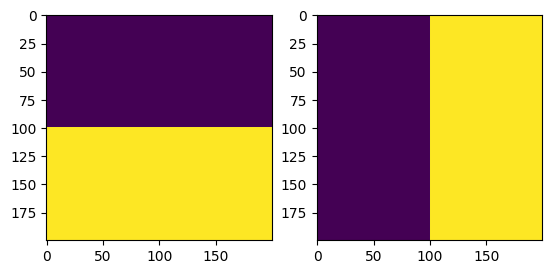

In [1]:
import numpy as np
import evaluate
from matplotlib import pyplot as plt

pred = np.zeros((200, 200), dtype=np.int32)
mask = np.zeros((200, 200), dtype=np.int32)

pred[100:, ...] = 1
mask[..., 100:] = 1

f, axs = plt.subplots(1, 2)
axs[0].imshow(pred)
axs[1].imshow(mask)

In [ ]:
import torch
from mmseg.evaluation.metrics.iou_metric import IoUMetric


gt_sem_seg_data = torch.zeros((200, 200), dtype=torch.int64)
pred_sem_seg_data = torch.zeros((200, 200), dtype=torch.int64)
gt_sem_seg_data[..., 100:] = 1
pred_sem_seg_data[100:, ...] = 1


data_sample = {"gt_sem_seg": {"data": gt_sem_seg_data}, "pred_sem_seg": {"data": pred_sem_seg_data}}
data_samples = [data_sample]

iou = IoUMetric(ignore_index=0)
iou.dataset_meta = dict(classes=["black", "white"])
iou.process([0] * len(data_samples), data_samples)
iou.evaluate(1)

## Output
# | Class | IoU  | Acc  |
# +-------+------+------+
# | black | 0.0  | nan  |
# | white | 50.0 | 50.0 |
# +-------+------+------+
# {'aAcc': 50.0, 'mIoU': 25.0, 'mAcc': 50.0}

In [ ]:
iou.compute_metrics(results=iou.results)

In [ ]:
from mmseg.core.evaluation.metrics import mean_iou as mmseg_miou

mmseg_miou(
    results=[pred],
    gt_seg_maps=[mask],
    num_classes=2,
    ignore_index=0,
    reduce_zero_label=False,
)